<a href="https://colab.research.google.com/github/shingi7/testing/blob/main/lab_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab-03: DBpedia14 classification with BERT

In Lab-01 we used linear text classification models (the perceptron, linear SVM, multinomial naive Bayes, softmax regression) on the DBpedia14 dataset. Recall that our best test accuracy was in the 92-93% range, and in lecture 07 we implemented a [feed-forward ANN](https://github.com/chrislarson1/GU-ANLY-5800-FALL-2024/tree/main/lectures/07/ann-demo.ipynb) with CBOW features to achieve ~98% test accuracy. Here we will use the BERT transformer model that is considerably larger and pretrained on vast amounts of text data to achieve >99% test accuracy with minimal hyperparameter tuning.

### Class labels

In [7]:
labels = {
    0: "Company",
    1: "EducationalInstitution",
    2: "Artist",
    3: "Athlete",
    4: "OfficeHolder",
    5: "MeanOfTransportation",
    6: "Building",
    7: "NaturalPlace",
    8: "Village",
    9: "Animal",
    10: "Plant",
    11: "Album",
    12: "Film",
    13: "WrittenWork"
}

K = len(labels)

## Download the dataset

In [8]:
# Colab provides limited GPU time (be mindful when increasing this number)
M = 30000

In [9]:
import datasets
import pandas as pd

df_train, df_test = datasets.load_dataset('dbpedia_14', split=['train[:80%]', 'test[80%:]'])
df_train = df_train.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.8 * M)]
df_test = df_test.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.2 * M)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.64k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/70000 [00:00<?, ? examples/s]

### Task 1: Analyze the data

a. What is the distribution of the labels in this data?

*Hint*: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html


<Axes: title={'center': 'Train Set Label Distribution'}, xlabel='label'>

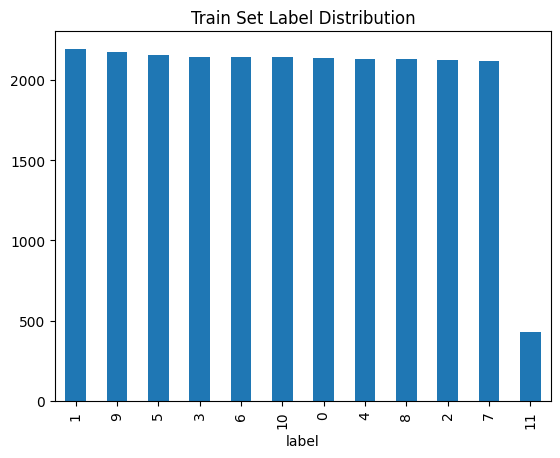

In [10]:
df_train['label'].value_counts().plot(kind='bar', title='Train Set Label Distribution')

<Axes: title={'center': 'Test Set Label Distribution'}, xlabel='label'>

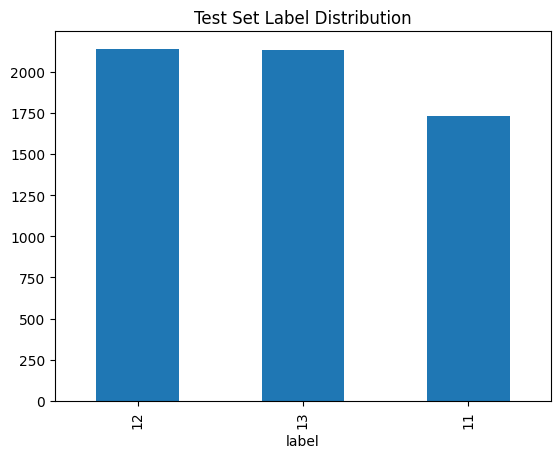

In [11]:
df_test['label'].value_counts().plot(kind='bar', title='Test Set Label Distribution')


b. Compute the distribution of sentence length in the dataset


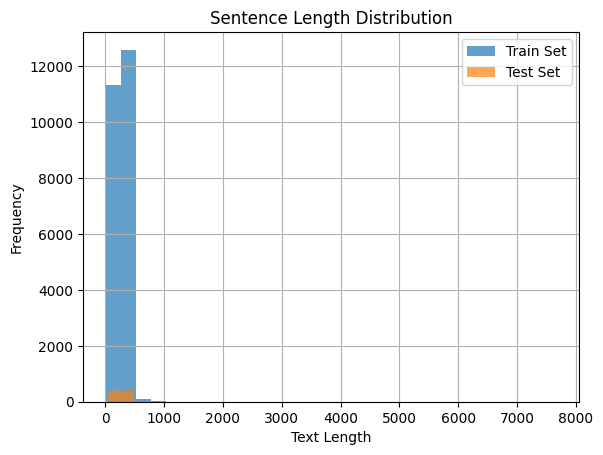

In [13]:
import matplotlib.pyplot as plt

df_train['text_length'] = df_train['content'].apply(len)
df_test['text_length'] = df_test['content'].apply(len)

df_train['text_length'].hist(bins=30, alpha=0.7, label='Train Set')
df_test['text_length'].hist(bins=30, alpha=0.7, label='Test Set')
plt.legend()
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution')
plt.show()

c. Are there any differences between the train and test sets? If so make any necessary changes to the train/test sets such that they look the same.

`Yes, there are differences.`

`For the label distribution, the train set has a balanced distribution except for label 11. The test set only has data for labels 11, 12, and 13.`

`However, we can't filter the training data to have only 11, 12, and 13 because it has no data for 12 and 13`


In [ ]:
#df_train = df_train[df_train['label'].isin([11, 12, 13])]

#df_train['label'].value_counts().plot(kind='bar', title='Filtered Train Set Label Distribution')
#plt.show()

## Train BERT on DBpedia14

Here you will use Google CoLab, which provides free (but limited) use of hosted GPU instances.

Before doing this, take a look at the leaderboard for DBpedia14: https://paperswithcode.com/dataset/dbpedia. You'll find various transformers (including BERT) at the top. Here we will use a smaller version of BERT called DistilBERT which reduces the computational overhead with only marginal performance degradation, and only two training epochs over an abridged version of the dataset.

### Google CoLab

To complete the tasks below you will need to login to a Google account and then go here: https://colab.research.google.com. Then do the following:

1. End any existing CoLab sessions that you have running

2. Click on the `Upload` tab and upload this file

3. Click on `Runtime -> Change runtime type` and select `GPU`

### Install packages

In [ ]:
#!pip install -q transformers torch

### Restart runtime

After running the cell above, click `Runtime -> Restart runtime`. This only needs to be done one time per session.

### Training Hyperparameters

In [14]:
batch_size = 32
epochs = 2
lr_init = 1e-5
max_len = 128
warmup_steps = 3

### Task 2: Create batched inputs using Huggingface's DistilBERT tokenizer

In [15]:
from typing import List, Tuple
import torch
from transformers import DistilBertTokenizerFast
from transformers.tokenization_utils_base import BatchEncoding

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
def batch_data(data: pd.DataFrame, bsize: int) -> List[Tuple[BatchEncoding, List[int], List[str]]]:
    """
    This Function accepts a Pandas DataFrame and a batch size and returns
    a list of training 'batches', each of which is a tuple of:
        ( X, Y, s )
    where
        X: BatchEncoding ∈ R^(`bsize` x `T_max` x `D`)    inputs
        Y: torch.Tensor ∈ Z^(`bsize` x `1`)               ground truth labels
        s: List[str] w/ len `bsize`                       sentences (i.e., documents)

    Note: refer to the `DistilBertTokenizerFast.batch_encode_plus()` method to produce X
    """
    # Your code goes here
    batches = []
    for i in range(0, len(data), bsize):
        batch = data.iloc[i:i + bsize]
        X = tokenizer.batch_encode_plus(
            batch['content'].tolist(),
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        Y = torch.tensor(batch['label'].tolist())
        s = batch['content'].tolist()
        batches.append((X, Y, s))
    return batches

### Create train/test splits

In [28]:
train_batches = batch_data(df_train, bsize=batch_size)
test_batches = batch_data(df_test, bsize=batch_size)

### Load pretrained Distilbert model

This cell uses the `DistilBertForSequenceClassification` class, which is a convenience wrapper that places a classification head onto the DistilBert language model.

In [29]:
from tqdm import tqdm
import torch
from transformers import DistilBertForSequenceClassification, \
  AdamW, get_linear_schedule_with_warmup

# Transformer model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased',
    num_labels=K,
    output_hidden_states=True)

# The torch `device` on which to execute the model computation
if torch.cuda.is_available():
    device = torch.device('cuda:0') # GPU
else:
    device = torch.device('cpu') # CPU
model.to(device)

# The gradient descent optimizer used for fine tuning
optimizer = AdamW(model.parameters(), lr=lr_init)

# The gradient descent learning rate
lr = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps,
    num_training_steps=len(train_batches))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Task 3: Implement a training loop from scratch

Here you need to:

1. Implement the `runner()` method below
2. Train the DistilBert model on the training set
3. Compute and print out the loss, accuracy, and f1-score of the trained model on the train and tests sets
4. Provide a brief summary of the results and place them in context to other modeling approaches (e.g.word2vec from lecture 05, the CBOW NN from lecture 07).

*Note: You're encouraged to use the Huggingface documentation to complete this task!*

*Note: This should take about 20 minutes on CoLabs K80 GPUs*

In [30]:
import evaluate
from sklearn.metrics import accuracy_score, f1_score

def runner(batches, desc: str, train=True):
    """
    This function accepts a list of batches (i.e., the output of batch_data())
    and returns a tuple consisting of:
        (predictions, cls-embeddings, mean-loss, accuracy, f1-score)
    where
        preditions: List[pred for each input]
        cls-embeddings: List[bert's cls embeddings for each input]
        mean-loss: mean loss computed over data in batches
        mean-accuracy: mean accuracy computed over data in batches
        mean-f1-score: mean f1 score computed over data in batches
    """
    model.train() if train else model.eval()
    total_loss, all_preds, all_labels, cls_embeddings = 0, [], [], []

    for X, Y, s in tqdm(batches, desc=desc):
        X, Y = {k: v.to(device) for k, v in X.items()}, Y.to(device)

        # No gradient calculation during evaluation
        with torch.set_grad_enabled(train):
            outputs = model(**X, labels=Y)
            loss, logits = outputs.loss, outputs.logits
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(Y.cpu().numpy())

            if train:
                loss.backward()
                optimizer.step()
                lr.step()
                optimizer.zero_grad()

            # Store CLS embeddings
            if hasattr(outputs, 'hidden_states'):
                cls_embed = outputs.hidden_states[-1][:, 0, :].detach().cpu().numpy()
            else:
                cls_embed = logits.detach().cpu().numpy()
            cls_embeddings.extend(cls_embed)

    mean_loss = total_loss / len(batches)
    mean_accuracy = accuracy_score(all_labels, all_preds)
    mean_f1 = f1_score(all_labels, all_preds, average='weighted')

    return all_preds, cls_embeddings, mean_loss, mean_accuracy, mean_f1

# Training
train_preds, train_cls, train_loss, train_acc, train_f1 = runner(train_batches, "Training")
print(f"Train Loss: {train_loss}, Train Acc: {train_acc}, Train F1: {train_f1}")

# Evaluation
test_preds, test_cls, test_loss, test_acc, test_f1 = runner(test_batches, "Evaluation", train=False)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}, Test F1: {test_f1}")

# Training
train_preds, train_cls, train_loss, train_acc, train_f1 = runner(train_batches, "Training")
print(f"Train Loss: {train_loss}, Train Acc: {train_acc}, Train F1: {train_f1}")

# Evaluation
test_preds, test_cls, test_loss, test_acc, test_f1 = runner(test_batches, "Evaluation", train=False)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}, Test F1: {test_f1}")

Training: 100%|██████████| 750/750 [03:58<00:00,  3.14it/s]


Train Loss: 0.4128865813612938, Train Acc: 0.9364166666666667, Train F1: 0.9389373000681774


Evaluation: 100%|██████████| 188/188 [00:20<00:00,  9.18it/s]


Test Loss: 3.1728243092273143, Test Acc: 0.28833333333333333, Test F1: 0.14223677964492548


Training: 100%|██████████| 750/750 [03:59<00:00,  3.13it/s]


Train Loss: 0.08510736568272113, Train Acc: 0.9909583333333334, Train F1: 0.9909585123506408


Evaluation: 100%|██████████| 188/188 [00:20<00:00,  9.21it/s]

Test Loss: 3.1728243092273143, Test Acc: 0.28833333333333333, Test F1: 0.14223677964492548


### Task 4: test your model on new string

Make up (or find) a document that maps to one of the 14 classes in DBpedia14. Is the model's prediction in agreement with your label assignment? The cell below contains some helper code to get you started. To compute the model prediction, reuse the `batch_data()` and `runner()` functions.

In [31]:
import numpy as np
import pandas as pd

example_text = """Her is a 2013 American science-fiction romantic drama film written,
directed, and produced by Spike Jonze. It marks Jonze's solo screenwriting debut.
The film follows Theodore Twombly (Joaquin Phoenix), a man who develops a relationship
with Samantha (Scarlett Johansson), an artificially intelligent virtual assistant
personified through a female voice."""

example_ground_truth_label = 12 # "film"

df = pd.DataFrame({'content': [example_text],
                   'label': example_ground_truth_label,
                   'title': None})

In [32]:
# Your code goes here
example_batches = batch_data(df, bsize=1)
example_preds, example_cls, _, _, _ = runner(example_batches, "Example Test", train=False)

predicted_label = example_preds[0]
print(f"Predicted Label: {labels[predicted_label]}")
print(f"Actual Label: {labels[example_ground_truth_label]}")


Example Test: 100%|██████████| 1/1 [00:00<00:00, 31.71it/s]

Predicted Label: Album
Actual Label: Film


### Task 5: Extract the document embeddings and visualize them in Tensorboard Projector

#### TSV helper functions

In [33]:
def save_matrix(matrix, fpath):
    D1, D2 = matrix.shape
    tsv = ""
    for i in range(D1):
        for j in range(D2):
            tsv += str(matrix[i, j]) + '\t'
        tsv = tsv.strip('\t') + '\n'
    tsv = tsv.strip('\n')
    with open(fpath, "w") as fd:
        fd.write(tsv)

def save_docs(docs, labels, fpath):
    tsv = "document\tlabel\n"
    for doc, label in zip(docs, labels):
        tsv += doc.lower().strip() + '\t' + label + '\n'
    tsv = tsv.strip('\n')
    with open(fpath, "w") as fd:
        fd.write(tsv)

### Extract embeddings

In [34]:
# Your code goes here
# Extract embeddings and labels for the train set
train_docs = [s for _, _, s in train_batches for s in s]
train_labels = [labels[l] for _, l, _ in train_batches for l in l.tolist()]

# Save CLS embeddings and document labels for visualization
train_embeddings_matrix = np.array(train_cls)
save_matrix(train_embeddings_matrix, '/content/cls_embeddings.tsv')
save_docs(train_docs, train_labels, '/content/documents.tsv')


### Visualize embeddings

The embeddings and text can be saved in tsv format and uploaded here  https://projector.tensorflow.org/ for visualization. Choose the tSNE algorithm.

In [ ]:
# Your code goes here